In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import torchvision.transforms.v2 as v2

import numpy as np
import pandas as pd
import math
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
from itertools import chain, pairwise
import random
from tqdm import tqdm
import sys
import os

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder

sys.path.append('./src')
from src.data import MultiSet, ImageTransforms, ProfileTransform, PairAugmentation
from src.profile_encoder import ProfileTransformer
from src.image_encoder import ImageEncoder
from src.model import MultiModel
from src.coordination import DistanceLoss, CLIPLoss, RankLoss
from src.zeroshot import ANNZeroShot

from lightning import Trainer
import logging

# from torch.utils.tensorboard import SummaryWriter
# from accelerate import Accelerator
# from accelerate.utils import GradientAccumulationPlugin

import scienceplots
plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

# %matplotlib widget

import timm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pacmap

%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


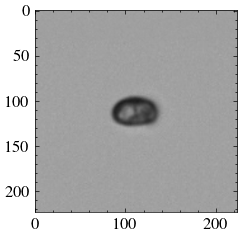

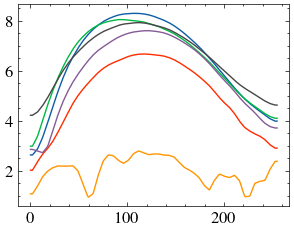

tensor(0.9406)

In [4]:
id = random.randint(0, len(test_set)-1)
data = test_set[id]

plt.imshow(data['image'].permute(1, 2, 0), cmap='gray', vmin=0, vmax=1)
plt.show()

plt.plot(data['profile'])
plt.show()

data['profile'].min()

In [31]:
annot = pd.read_csv(data_path / 'train.csv')
annot

,Unnamed: 0,ID,class_name
0,581,582,Aphanizomenon_flosaquae
1,643,644,Aphanizomenon_flosaquae
2,679,680,Aphanizomenon_flosaquae
3,492,493,Aphanizomenon_flosaquae
4,744,745,Aphanizomenon_flosaquae
...,...,...,...
6139,19317,19318,Tetraselmis_sp
6140,19284,19285,Tetraselmis_sp
6141,19325,19326,Tetraselmis_sp
6142,19509,19510,Tetraselmis_sp


In [66]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for train, test in kfold.split(annot, annot.class_name):
    print(annot.iloc[test])


      Unnamed: 0     ID               class_name
21           793    794  Aphanizomenon_flosaquae
26           794    795  Aphanizomenon_flosaquae
29           184    185  Aphanizomenon_flosaquae
37           208    209  Aphanizomenon_flosaquae
38           520    521  Aphanizomenon_flosaquae
...          ...    ...                      ...
6106       19904  19905           Tetraselmis_sp
6109       19592  19593           Tetraselmis_sp
6111       20026  20027           Tetraselmis_sp
6116       19343  19344           Tetraselmis_sp
6137       19604  19605           Tetraselmis_sp

[1229 rows x 3 columns]
      Unnamed: 0     ID               class_name
1            643    644  Aphanizomenon_flosaquae
3            492    493  Aphanizomenon_flosaquae
8            832    833  Aphanizomenon_flosaquae
15           486    487  Aphanizomenon_flosaquae
19           425    426  Aphanizomenon_flosaquae
...          ...    ...                      ...
6129       19578  19579           Tetraselmi

In [9]:
annotation_id = 'test'
max_len = 256

data_path = Path('./data/CytoSense') / annotation_id

image_transforms = ImageTransforms()
signal_transforms = ProfileTransform(max_len=max_len)
pair_augmentation = PairAugmentation()

train_set = MultiSet(annotation_path=data_path / f'train.csv', 
                   image_transforms=image_transforms,
                   profile_transform=signal_transforms,
                   pair_augmentation=pair_augmentation)

test_set = MultiSet(annotation_path=data_path / f'test.csv', 
                    image_transforms=image_transforms,
                    profile_transform=signal_transforms,
                    pair_augmentation=None)

def multi_collate(batch, model=model):
    
    image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))
    
    image = {'image': torch.stack(image)}
    profile = model.profile_encoder.tokenize(profile)
    label = {'label': label}
    image_shape = {'image_shape': torch.stack(image_shape)}
    profile_len = {'profile_len': torch.stack(profile_len)}

    return image | profile | label | image_shape | profile_len


loader = DataLoader(test_set, batch_size=32, collate_fn=multi_collate)

In [20]:
x = next(iter(loader))['profile']
x.transpose(1, 2).shape

torch.Size([32, 6, 256])

In [ ]:
train_set.table

,Unnamed: 0,image,profile,class
0,923,Aphanizomenon_flosaquae/UtoF_FLR_L 2020-07-13 ...,Aphanizomenon_flosaquae/UtoF_FLR_L 2020-07-13 ...,Aphanizomenon_flosaquae
1,259,Aphanizomenon_flosaquae/UtoF_FLR_L 2020-07-10 ...,Aphanizomenon_flosaquae/UtoF_FLR_L 2020-07-10 ...,Aphanizomenon_flosaquae
2,1195,Aphanizomenon_flosaquae/UtoF_FLR_L 2020-07-14 ...,Aphanizomenon_flosaquae/UtoF_FLR_L 2020-07-14 ...,Aphanizomenon_flosaquae
3,1152,Aphanizomenon_flosaquae/UtoF_FLR_L 2020-07-14 ...,Aphanizomenon_flosaquae/UtoF_FLR_L 2020-07-14 ...,Aphanizomenon_flosaquae
4,27,Aphanizomenon_flosaquae/D205_FLR_L 2020-07-09 ...,Aphanizomenon_flosaquae/D205_FLR_L 2020-07-09 ...,Aphanizomenon_flosaquae
...,...,...,...,...
395,9295,Small centric/PD_08_D2_FLR_L 2020-09-10 09h36_...,Small centric/PD_08_D2_FLR_L 2020-09-10 09h36_...,Small centric
396,9297,Small centric/PD_08_D9_FLR_L 2020-09-17 10h43_...,Small centric/PD_08_D9_FLR_L 2020-09-17 10h43_...,Small centric
397,9238,Small centric/PD_01_D6_FLR_L 2020-09-14 08h20_...,Small centric/PD_01_D6_FLR_L 2020-09-14 08h20_...,Small centric
398,9260,Small centric/PD_02_D3_FLR_L 2020-09-11 08h20_...,Small centric/PD_02_D3_FLR_L 2020-09-11 08h20_...,Small centric


# Lab data

In [31]:
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

def normalize(X):
    return X / np.linalg.norm(X, axis=1, keepdims=True)

names = (
    'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus',
    # 'efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus',
    'vit_t_16_transformer_2_512_clip_FASTVISION-plus',
    # 'vit_t_16_transformer_2_512_siglip_FASTVISION-plus',
)

embeddings = {name: {} for name in names}

for name in names: 
    for i in range(1, 2):
        path = Path(f'logs/{name}_fold{i}/version_1/checkpoints')
        checkpoint = list(path.iterdir())[0]
        print(checkpoint)

        model = MultiModel.load_from_checkpoint(checkpoint)
        max_len = 256
        data_path = Path(f'./data/FASTVISION-plus/fold{i}')

        image_transforms = ImageTransforms()
        signal_transforms = ProfileTransform(max_len=max_len)
        pair_augmentation = PairAugmentation()

        train_set = MultiSet(annotation_path=data_path / f'train.csv', 
                           image_transforms=image_transforms,
                           profile_transform=signal_transforms,
                           pair_augmentation=pair_augmentation)

        test_set = MultiSet(annotation_path=data_path / f'test.csv', 
                            image_transforms=image_transforms,
                            profile_transform=signal_transforms,
                            pair_augmentation=None)

        def multi_collate(batch, model=model):
    
            image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))
    
            image = {'image': torch.stack(image)}
            profile = model.profile_encoder.tokenize(profile)
            label = {'label': label}
            image_shape = {'image_shape': torch.stack(image_shape)}
            profile_len = {'profile_len': torch.stack(profile_len)}
    
            return image | profile | label | image_shape | profile_len
    
        train_loader = DataLoader(dataset=train_set, batch_size=128, 
                                  num_workers=8, collate_fn=multi_collate)
    
        test_loader = DataLoader(dataset=test_set, batch_size=128, 
                                 num_workers=8, collate_fn=multi_collate)
    
        trainer = Trainer(barebones=True)
    
        train = trainer.predict(model, train_loader)
        image_train, profile_train, label_train = zip(*(sample.values() for sample in train))
    
        test = trainer.predict(model, test_loader)
        image_test, profile_test, label_test = zip(*(sample.values() for sample in test))

        I_train = normalize(torch.cat(image_train).numpy())
        P_train = normalize(torch.cat(profile_train).numpy())
        L_train = np.concatenate(label_train)
    
        I_test = normalize(torch.cat(image_test).numpy())
        P_test = normalize(torch.cat(profile_test).numpy())
        L_test = np.concatenate(label_test)

        embeddings[name][i] = {
            'train': {
                'image': I_train,
                'profile': P_train,
                'label': L_train,
            },
            'test': {
                'image': I_test,
                'profile': P_test,
                'label': L_test,
            },
            'classes': np.unique(L_train)
        }

logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold1/version_1/checkpoints/epoch=55_valid_loss=0.94803.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold1/version_1/checkpoints/epoch=70_valid_loss=1.41176.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


In [ ]:
np.concatenate(label_train).shape

(400,)

# Sea data

In [ ]:
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

def normalize(X):
    return X / np.linalg.norm(X, axis=1, keepdims=True)

names = (
    'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus',
    'efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus',
    'vit_t_16_transformer_2_512_clip_FASTVISION-plus',
    'vit_t_16_transformer_2_512_siglip_FASTVISION-plus',
)

embeddings = {name: {} for name in names}

for name in names: 
    for i in range(1, 6):
        path = Path(f'logs/{name}_fold{i}/version_0/checkpoints')
        checkpoint = list(path.iterdir())[0]
        print(checkpoint)

        model = MultiModel.load_from_checkpoint(checkpoint)
        max_len = 256
        data_path = Path(f'./data/CytoSense/test')

        image_transforms = ImageTransforms()
        signal_transforms = ProfileTransform(max_len=max_len)
        pair_augmentation = PairAugmentation()

        train_set = MultiSet(annotation_path=data_path / f'train.csv', 
                           image_transforms=image_transforms,
                           profile_transform=signal_transforms,
                           pair_augmentation=pair_augmentation)

        test_set = MultiSet(annotation_path=data_path / f'test.csv', 
                            image_transforms=image_transforms,
                            profile_transform=signal_transforms,
                            pair_augmentation=None)

        def multi_collate(batch, model=model):
    
            image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))
    
            image = {'image': torch.stack(image)}
            profile = model.profile_encoder.tokenize(profile)
            label = {'label': label}
            image_shape = {'image_shape': torch.stack(image_shape)}
            profile_len = {'profile_len': torch.stack(profile_len)}
    
            return image | profile | label | image_shape | profile_len
    
        train_loader = DataLoader(dataset=train_set, batch_size=128, 
                                  num_workers=8, collate_fn=multi_collate)
    
        test_loader = DataLoader(dataset=test_set, batch_size=128, 
                                 num_workers=8, collate_fn=multi_collate)
    
        trainer = Trainer(barebones=True)
    
        train = trainer.predict(model, train_loader)
        image_train, profile_train, label_train = zip(*(sample.values() for sample in train))
    
        test = trainer.predict(model, test_loader)
        image_test, profile_test, label_test = zip(*(sample.values() for sample in test))

        I_train = normalize(torch.cat(image_train).numpy())
        P_train = normalize(torch.cat(profile_train).numpy())
        L_train = np.concatenate(label_train)
    
        I_test = normalize(torch.cat(image_test).numpy())
        P_test = normalize(torch.cat(profile_test).numpy())
        L_test = np.concatenate(label_test)

        embeddings[name][i] = {
            'train': {
                'image': I_train,
                'profile': P_train,
                'label': L_train,
            },
            'test': {
                'image': I_test,
                'profile': P_test,
                'label': L_test,
            },
            'classes': np.unique(L_train)
        }

logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=96_valid_loss=0.35709.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=127_valid_loss=0.35143.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=151_valid_loss=0.34816.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=141_valid_loss=0.35187.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold5/version_0/checkpoints/epoch=153_valid_loss=0.35694.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=10_valid_loss=2.26496.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=13_valid_loss=2.27297.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=9_valid_loss=2.33835.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=10_valid_loss=2.31275.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold5/version_0/checkpoints/epoch=10_valid_loss=2.35630.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=78_valid_loss=0.69465.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=42_valid_loss=0.68820.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=52_valid_loss=0.66013.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=37_valid_loss=0.73846.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_clip_FASTVISION-plus_fold5/version_0/checkpoints/epoch=88_valid_loss=0.62044.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=162_valid_loss=1.45968.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=77_valid_loss=1.71902.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=134_valid_loss=1.47112.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=56_valid_loss=1.79381.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


logs/vit_t_16_transformer_2_512_siglip_FASTVISION-plus_fold5/version_0/checkpoints/epoch=78_valid_loss=1.65592.ckpt


/home/veikka_immonen/miniconda3/envs/fastvision/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/veikka_immonen/miniconda3/envs/fastvision/lib/ ...


In [13]:
import pickle

with open('embeddings_sea.pkl', 'wb') as buf:
    pickle.dump(embeddings, buf)

In [2]:
import pickle

with open('embeddings_lab.pkl', 'rb') as buf:
    embeddings = pickle.load(buf)

embeddings

{'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus': {1: {'train': {'image': array([[ 0.07956216, -0.06209254, -0.05971374, ...,  0.02551104,
            -0.08174506, -0.51407284],
           [-0.1729036 , -0.0934246 , -0.26376972, ...,  0.23597202,
             0.07135702, -0.03766857],
           [-0.09184708, -0.12323436, -0.10765399, ..., -0.10501836,
             0.09256658, -0.11270435],
           ...,
           [ 0.23714702, -0.18734267, -0.5979023 , ..., -0.12374232,
            -0.26894957,  0.2905969 ],
           [ 0.31448212,  0.00662235,  0.20465812, ..., -0.3505348 ,
            -0.5840976 ,  0.31129408],
           [ 0.2396777 , -0.08782725, -0.38557497, ...,  0.04630073,
             0.05293717,  0.40353703]], shape=(16040, 512), dtype=float32),
    'profile': array([[-0.6623137 , -0.88200575, -0.5443681 , ...,  0.19163641,
             0.1497084 , -0.07595125],
           [-0.59568036, -0.9560027 , -0.7949002 , ...,  0.89515316,
             0.9173353 ,  1.5009861 ],
 

In [33]:
np.random.seed(0)

K = (3, 15)
names = embeddings.keys()
data = {name: {k: {'metrics': [], 'pred': []} for k in K} | {'true': []} for name in names}
coder = LabelEncoder().fit(embeddings['efficientnet_b0_cnn_2_512_clip_FASTVISION-plus'][1]['classes'])

for name, folds in list(embeddings.items())[:]:

    for fold in tqdm(range(1, 2)):
        
        image_train = folds[fold]['train']['image']
        profile_train = folds[fold]['train']['profile']
        label_train = coder.transform(folds[fold]['train']['label'])

        image_test = folds[fold]['test']['image']
        profile_test = folds[fold]['test']['profile']
        label_test = coder.transform(folds[fold]['test']['label'])
        data[name]['true'].append(label_test)

        X = np.concatenate((image_train, profile_train))
        y = np.tile(label_train, (2,))
    
        predictor = ANNZeroShot(X, y, n_neighbors=128, metric='euclidean',
                                diversify_prob=0.0,
                                pruning_degree_multiplier=3.0)
        for k in K:
            pred = predictor.predict(image_test, profile_test, k=k, epsilon=0.3)
            acc = accuracy_score(label_test, pred)
            rest = precision_recall_fscore_support(label_test, pred, average='macro')
            data[name][k]['metrics'].append((acc,) + rest[:-1])
            data[name][k]['pred'].append(pred)


100%|██████████| 1/1 [00:34<00:00, 34.37s/it]


In [34]:
data

{'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus': {3: {'metrics': [(0.9897755610972568,
     0.9887868224774108,
     0.9890086400555612,
     0.9888462134901008)],
   'pred': [array([ 0.,  0.,  0., ..., 23., 23.,  5.], shape=(4010,))]},
  15: {'metrics': [(0.9890274314214463,
     0.9881232912369838,
     0.9879485530462321,
     0.9880008402020182)],
   'pred': [array([ 0.,  0.,  0., ..., 23., 23.,  5.], shape=(4010,))]},
  'true': [array([ 0,  0,  0, ..., 23, 23, 23], shape=(4010,))]},
 'vit_t_16_transformer_2_512_clip_FASTVISION-plus': {3: {'metrics': [(0.9825436408977556,
     0.9811242298006754,
     0.9807375691985257,
     0.9808310644512463)],
   'pred': [array([ 0.,  0.,  0., ..., 23., 23., 23.], shape=(4010,))]},
  15: {'metrics': [(0.9807980049875312,
     0.9796098929733376,
     0.979017419263708,
     0.9791649121049204)],
   'pred': [array([ 0.,  0.,  0., ..., 23., 23., 23.], shape=(4010,))]},
  'true': [array([ 0,  0,  0, ..., 23, 23, 23], shape=(4010,))]}}

In [36]:
for name in names:
    true = data[name]['true']
    print(f'{name}:')
    for k in K:
        metrics = data[name][k]['metrics']
        mu = np.mean(metrics, 0)
        std = np.std(metrics, 0)
        vals = chain(*zip(mu, std))
        print(f'k={k:3d}' + (' {:.2%}' * 8).format(*vals))
    print()

efficientnet_b0_cnn_2_512_clip_FASTVISION-plus:
k=  3 98.98% 0.00% 98.88% 0.00% 98.90% 0.00% 98.88% 0.00%
k= 15 98.90% 0.00% 98.81% 0.00% 98.79% 0.00% 98.80% 0.00%

vit_t_16_transformer_2_512_clip_FASTVISION-plus:
k=  3 98.25% 0.00% 98.11% 0.00% 98.07% 0.00% 98.08% 0.00%
k= 15 98.08% 0.00% 97.96% 0.00% 97.90% 0.00% 97.92% 0.00%



In [4]:
for name in names:
    true = data[name]['true']
    print(f'{name}:')
    for k in K:
        metrics = data[name][k]['metrics']
        mu = np.mean(metrics, 0)
        std = np.std(metrics, 0)
        vals = chain(*zip(mu, std))
        print(f'k={k:3d}' + (' {:.2%}' * 8).format(*vals))
    print()

efficientnet_b0_cnn_2_512_clip_FASTVISION-plus:
k=  3 98.79% 0.13% 98.73% 0.15% 98.68% 0.12% 98.69% 0.13%
k= 15 98.58% 0.09% 98.53% 0.11% 98.44% 0.09% 98.47% 0.10%
k= 51 98.12% 0.17% 98.06% 0.18% 97.92% 0.17% 97.97% 0.17%
k=101 97.72% 0.23% 97.68% 0.21% 97.47% 0.25% 97.53% 0.23%

efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus:
k=  3 98.64% 0.45% 98.54% 0.49% 98.52% 0.48% 98.52% 0.49%
k= 15 98.59% 0.41% 98.52% 0.43% 98.46% 0.43% 98.47% 0.44%
k= 51 98.11% 0.52% 98.04% 0.52% 97.93% 0.55% 97.96% 0.55%
k=101 97.70% 0.60% 97.65% 0.60% 97.47% 0.66% 97.51% 0.65%

vit_s_16_transformer_2_512_clip_FASTVISION-plus:
k=  3 98.36% 0.19% 98.28% 0.19% 98.18% 0.21% 98.22% 0.20%
k= 15 98.32% 0.12% 98.28% 0.10% 98.12% 0.17% 98.18% 0.13%
k= 51 97.94% 0.28% 97.93% 0.25% 97.67% 0.34% 97.76% 0.30%
k=101 97.60% 0.40% 97.61% 0.35% 97.26% 0.49% 97.39% 0.44%

vit_s_16_transformer_2_512_siglip_FASTVISION-plus:
k=  3 98.02% 0.43% 97.96% 0.45% 97.81% 0.46% 97.86% 0.46%
k= 15 98.08% 0.41% 98.05% 0.41% 97.87% 0.45% 

{'metrics': [(0.9875311720698254,
   0.9861275684194323,
   0.9866566996956928,
   0.9863323533617225),
  (0.9877805486284289,
   0.9868123034727416,
   0.985796545859881,
   0.9862520057522292),
  (0.985286783042394,
   0.9845829165200999,
   0.983700270332292,
   0.9840513223538044),
  (0.9832917705735661,
   0.9818139638082203,
   0.9825052572134515,
   0.981928399572323),
  (0.9865336658354115,
   0.9858165442171303,
   0.9853606355957591,
   0.9854894994402598)],
 'pred': [array([ 0.,  0.,  0., ..., 23., 23., 23.], shape=(4010,)),
  array([ 0.,  0.,  0., ..., 23., 23., 23.], shape=(4010,)),
  array([ 0.,  0.,  0., ..., 23., 23.,  5.], shape=(4010,)),
  array([ 0.,  0.,  0., ..., 23., 23., 23.], shape=(4010,)),
  array([ 0.,  0.,  0., ..., 23., 23., 23.], shape=(4010,))]}

/tmp/ipykernel_1757932/3896056013.py:16: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 2 Axes> than <Figure size 350x262.5 with 2 Axes> which fig.colorbar is called on.
  plt.colorbar(cm.im_, cax=cax) # Similar to fig.colorbar(im, cax = cax)


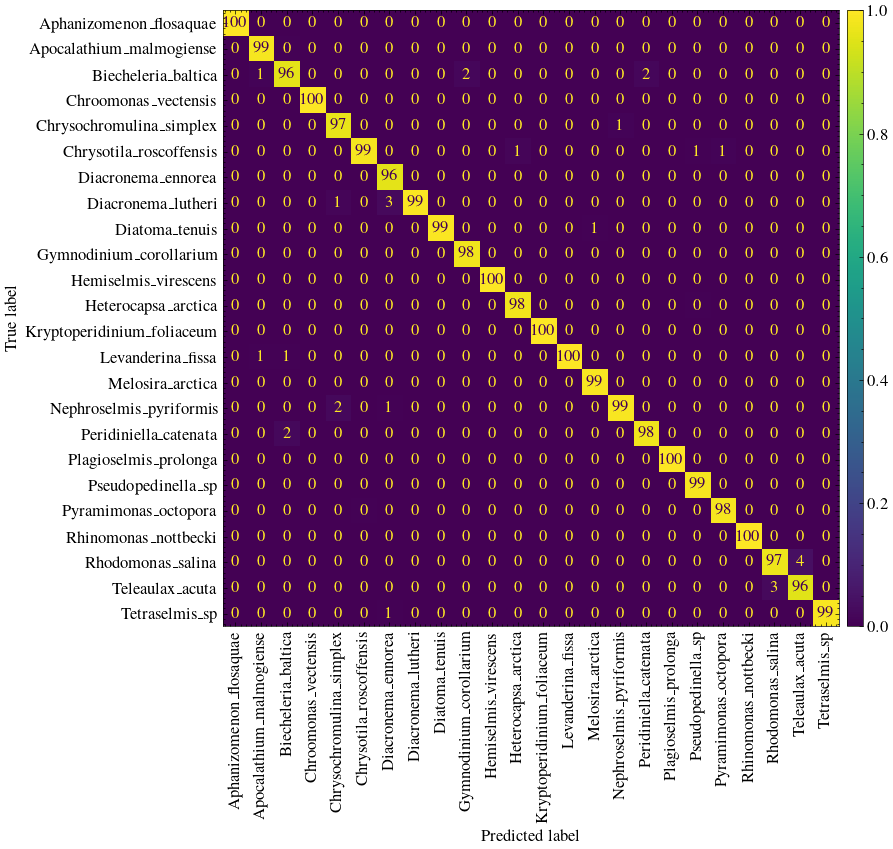

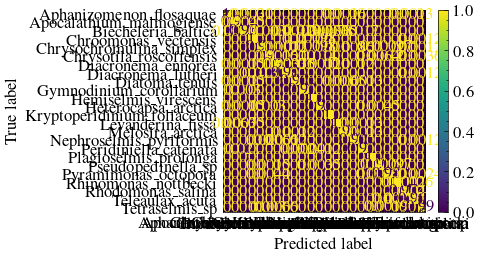

In [ ]:
reference = data['efficientnet_b0_cnn_2_512_clip_FASTVISION-plus']
results = reference[3]

pred = np.concatenate(results['pred'])
true = np.concatenate(reference['true'])

fig, ax = plt.subplots(figsize=(8, 8))
cm = ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=reference[1]['classes'], normalize='pred')

cm.plot(ax=ax, colorbar=False, values_format='.0%')
ax.tick_params(axis='x', labelrotation=90)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cm.im_, cax=cax) # Similar to fig.colorbar(im, cax = cax)

# fig.savefig('figures/efficientnet_b0_cnn_2_512_clip.pdf')

In [84]:
print(classification_report(true, pred, digits=4, target_names=reference[1]['classes']))


                                    precision    recall  f1-score   support

           Aphanizomenon_flosaquae     0.9962    0.9588    0.9771      1626
                      Chroococales     0.9556    0.9900    0.9725       804
                  Chrysochromulina     0.4753    0.9298    0.6291       114
                           Ciliata     0.7188    0.6765    0.6970        34
                   Cryptomonadales     0.0553    0.5778    0.1010        90
           Cryptophyceae-Teleaulax     0.9661    0.6331    0.7649      2562
                       Dinophyceae     0.5846    0.8172    0.6816       186
Dolichospermum-Anabaenopsis-coiled     0.6667    0.7742    0.7164       124
       Dolichospermum_Anabaenopsis     0.3803    0.5870    0.4615        46
                    Euglenophyceae     0.1393    0.5000    0.2179        34
                   Eutreptiella_sp     0.9259    0.4832    0.6350       983
             Heterocapsa_rotundata     0.3929    0.8148    0.5301       297
           

In [27]:
import random
np.random.seed(0)


def sample(y, n):
    idx = []
    orig = np.arange(len(y))
    for label in np.unique(y):
        i = list(orig[y == label])
        j = random.sample(i, n)
        idx.extend(j)
    return np.array(idx)


def test_subset(train, test, n, repeats=10):
    image_train, profile_train, label_train = train
    image_test, profile_test, label_test = test
    accs = []
    for _ in range(repeats):
        idx = sample(label_train, n)
        X = np.concatenate((image_train[idx], profile_train[idx]))
        y = np.tile(label_train[idx], (2,))
        predictor = ANNZeroShot(X, y, n_neighbors=128, metric='euclidean', diversify_prob=0.0, pruning_degree_multiplier=3.0)
        pred = predictor.predict(image_test, profile_test, k=3, epsilon=0.2)
        accs.append(accuracy_score(label_test, pred))
    return accs

N = (5, 10, 20, 40,)# 80, 160, 320,)
results = {name: [] for name in embeddings.keys()}

for name, data in tqdm(embeddings.items()):
    for n in N:
        accs = []
        for fold in range(1, 6):
            train = data[fold]['train'].values()
            test = data[fold]['test'].values()
            accs.append(test_subset(train, test, n))
        results[name].append(np.mean(accs))

100%|██████████| 4/4 [30:33<00:00, 458.36s/it]


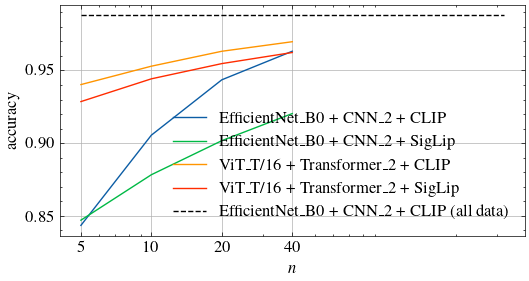

In [29]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.set_xlabel('$n$')
ax.set_ylabel('accuracy')
ax.set_xscale('log')
ax.set_xticks(N, N)

legends = {
    'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus': 'EfficientNet_B0 + CNN_2 + CLIP',
    'efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus': 'EfficientNet_B0 + CNN_2 + SigLip',
    'vit_t_16_transformer_2_512_clip_FASTVISION-plus': 'ViT_T/16 + Transformer_2 + CLIP',
    'vit_t_16_transformer_2_512_siglip_FASTVISION-plus': 'ViT_T/16 + Transformer_2 + SigLip',
}


for name, accs in results.items():
    ax.plot(N, accs, label=legends[name])

mu = 0.9879
ax.plot((5, 320), (mu, mu), 'k--', label='EfficientNet_B0 + CNN_2 + CLIP (all data)')

ax.legend()
ax.grid()
# plt.savefig('figures/subset.pdf')
plt.show()

In [41]:
def benchmark(embs_train, y_train, embs_test, y_test, K=(3, 15, 51, 101)):
    X = np.concatenate(embs_train)
    y = np.tile(y_train, (len(embs_train),))
    predictor = ANNZeroShot(X, y, n_neighbors=128, metric='cosine', diversify_prob=0.0, pruning_degree_multiplier=3.0)
    results = []
    for k in K:
        pred = predictor.predict(*embs_test, k=k, epsilon=0.2)
        acc = accuracy_score(y_test, pred)
        metrics = precision_recall_fscore_support(y_test, pred, average='macro')
        results.append((acc,) + metrics[:-1])
    return results

train_types = ('I', 'P', 'I', 'P')
test_types = ('I', 'P', 'I+P', 'I+P')
results = {name: {fold: [] for fold in range(1, 6)} for name in embeddings.keys()}

for name, data in embeddings.items():
    for fold in tqdm(range(1, 6)):

        image_train = data[fold]['train']['image']
        profile_train = data[fold]['train']['profile']
        label_train = data[fold]['train']['label']

        image_test = data[fold]['test']['image']
        profile_test = data[fold]['test']['profile']
        label_test = data[fold]['test']['label']

        train = (image_train, profile_train, image_train, profile_train)
        test = ((image_test,), (profile_test,), (image_test, profile_test), (image_test, profile_test))

        for train_embs, test_embs in zip(train, test):
            out = benchmark((train_embs,), label_train, test_embs, label_test, K=(3,))[0][0]
            results[name][fold].append(out)

100%|██████████| 5/5 [04:43<00:00, 56.67s/it]


In [43]:
for name, result, in results.items():
    print(name[:-16])
    values = list(result.values())
    for mu, std, train_type, test_type in zip(np.mean(values, 0), np.std(values, 0), train_types, test_types):
        print(f'{train_type:2s}& {test_type:4s}& {mu:.2%}$\\pm${std:.2%} \\\\')

efficientnet_b0_cnn_2_512_clip
I & I   & 96.15%$\pm$0.34% \\
P & P   & 98.15%$\pm$0.25% \\
I & I+P & 97.16%$\pm$0.30% \\
P & I+P & 98.33%$\pm$0.34% \\
efficientnet_b0_cnn_2_512_siglip
I & I   & 95.61%$\pm$0.89% \\
P & P   & 97.82%$\pm$0.42% \\
I & I+P & 96.13%$\pm$0.84% \\
P & I+P & 97.98%$\pm$0.50% \\
vit_s_16_transformer_2_512_clip
I & I   & 96.14%$\pm$0.21% \\
P & P   & 97.08%$\pm$0.27% \\
I & I+P & 96.71%$\pm$0.18% \\
P & I+P & 97.32%$\pm$0.22% \\
vit_s_16_transformer_2_512_siglip
I & I   & 95.23%$\pm$0.73% \\
P & P   & 96.43%$\pm$0.69% \\
I & I+P & 95.91%$\pm$0.67% \\
P & I+P & 96.70%$\pm$0.70% \\


In [ ]:
best = (3, 3, 3, 15)
labels = 
for k, name in zip(best, names):
    true

[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]
[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]
[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]
[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]


In [ ]:
# model = MultiModel.load_from_checkpoint('./logs/efficientnet_b0_cnn_1_unsupervised_128_FASTVISION-plus_fold1/version_0/checkpoints/epoch=80_valid_loss=0.85036.ckpt')
# model = MultiModel.load_from_checkpoint('./logs/CLIP_ef0_cnn1_FASTVISION-plus_fold1/version_9/checkpoints/epoch=67_valid_loss=0.83432.ckpt')
# model = MultiModel.load_from_checkpoint('./logs/CLIP_ef0_cnn2_FASTVISION-plus_fold1/version_2/checkpoints/epoch=82_valid_loss=0.81728.ckpt')
model = MultiModel.load_from_checkpoint(checkpoint)


def multi_collate(batch, model=model):

    image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))

    image = {'image': torch.stack(image)}
    profile = model.profile_encoder.tokenize(profile)
    label = {'label': model.name_to_id(label)}
    image_shape = {'image_shape': torch.stack(image_shape)}
    profile_len = {'profile_len': torch.stack(profile_len)}

    return image | profile | label | image_shape | profile_len

train_loader = DataLoader(dataset=train_set, batch_size=128, 
                          num_workers=8, collate_fn=multi_collate)

test_loader = DataLoader(dataset=test_set, batch_size=128, 
                         num_workers=8, collate_fn=multi_collate)

trainer = Trainer()

train = trainer.predict(model, train_loader)
image_train, profile_train, label_train = zip(*(sample.values() for sample in train))

test = trainer.predict(model, test_loader)
image_test, profile_test, label_test = zip(*(sample.values() for sample in test))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [19]:
I_train = torch.cat(image_train).numpy()
P_train  = torch.cat(profile_train).numpy()
L_train = torch.cat(label_train).numpy()

I_test = torch.cat(image_test).numpy()
P_test  = torch.cat(profile_test).numpy()
L_test = torch.cat(label_test).numpy()

In [20]:
X = np.concatenate((I_train, P_train))
y = np.tile(L_train, (2,))

predictor = ANNZeroShot(X, y, n_neighbors=128, metric='cosine', diversify_prob=0.0, pruning_degree_multiplier=3.0)

In [27]:
pred = predictor.predict(I_test, P_test, k=9, epsilon=0.2)

(pred == L_test).mean()

np.float64(0.985785536159601)

In [ ]:
index = NNDescent(
    data,
    n_neighbors=64,
    metric='cosine',
    diversify_prob=0.,
    pruning_degree_multiplier=3.
)
index.prepare()

In [21]:
%matplotlib inline

In [85]:
foo = embeddings['efficientnet_b0_cnn_2_512_clip_FASTVISION-plus'][1]['train']
image_emb = foo['image']
profile_emb = foo['profile']
label = LabelEncoder().fit_transform(foo['label'])

In [46]:
from sklearn.decomposition import KernelPCA

In [90]:
# I_e = torch.cat(image_emb).numpy()
# P_e = torch.cat(profile_emb).numpy()
I_e = image_emb / np.linalg.norm(image_emb, axis=1, keepdims=True)
P_e = profile_emb / np.linalg.norm(profile_emb, axis=1, keepdims=True)
# L = torch.cat(label).numpy()

Et = np.concat((I_e, P_e))
Lt = np.tile(label, (2,))

# plt.hist(np.linalg.norm(I_e, axis=1), alpha=0.5)
# plt.hist(np.linalg.norm(P_e, axis=1), alpha=0.5)

# mapping = pacmap.PaCMAP(n_components=2, n_neighbors=3, MN_ratio=.5) 
# mapping = KernelPCA(2, kernel='rbf')
mapping = TSNE(2)
reduced = mapping.fit_transform(Et)

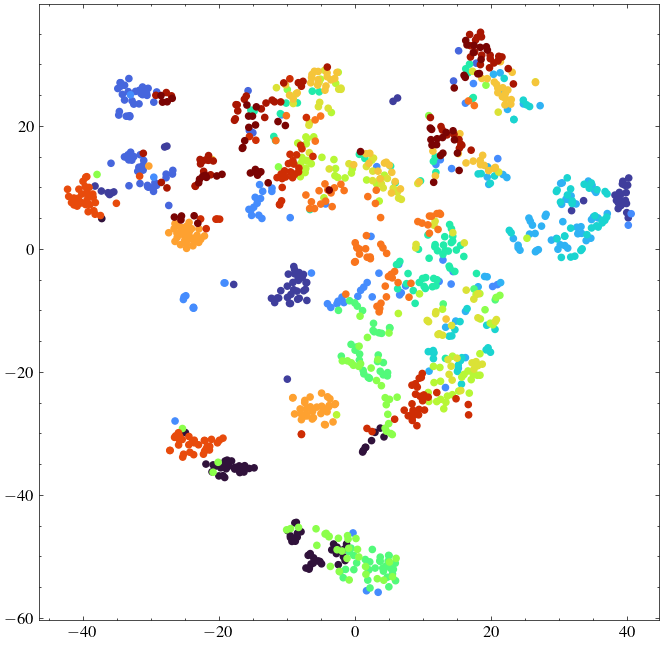

In [93]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(*reduced.T, c=Lt, cmap='turbo', s=20)

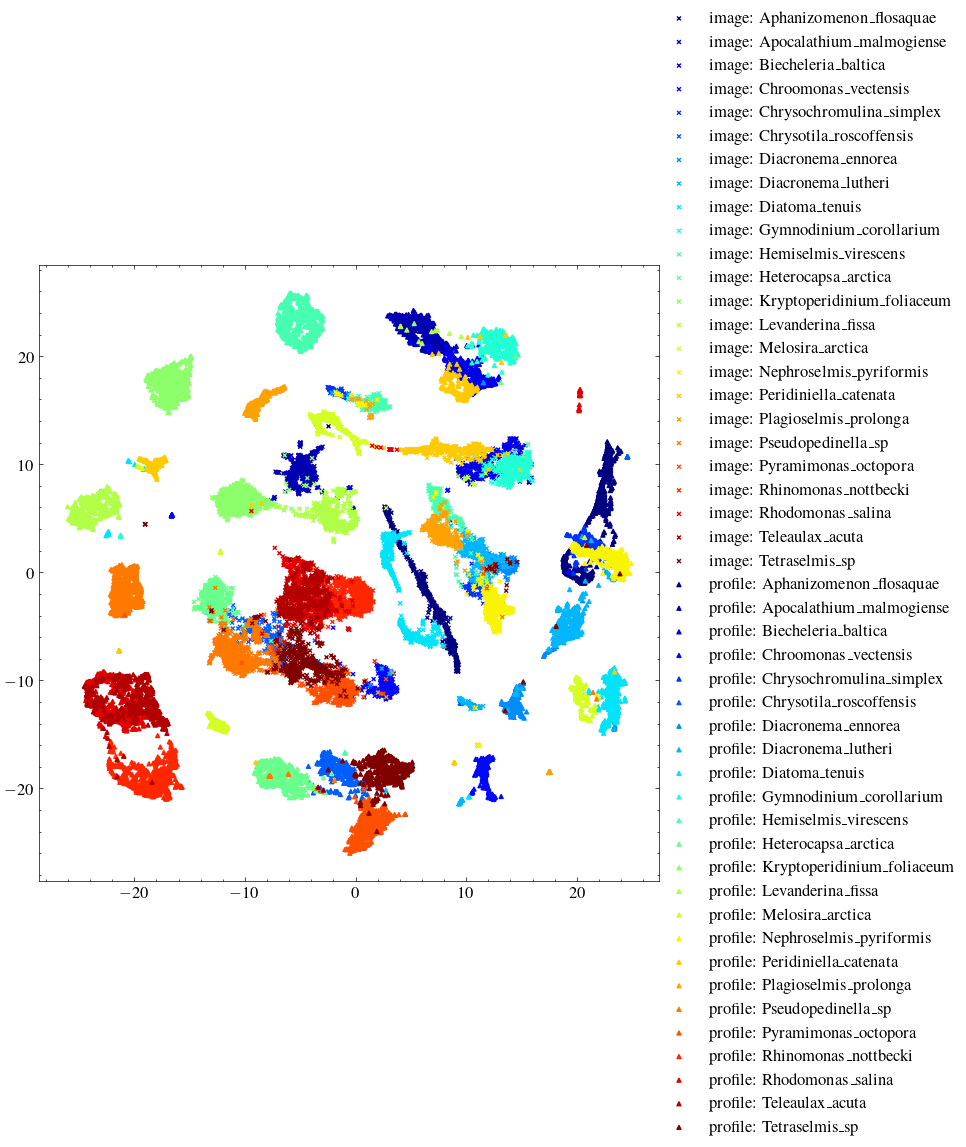

In [12]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.get_cmap(name, n)

fig = plt.figure()
ax = fig.add_subplot()

cmap = get_cmap(len(model.label_encoder.classes_), 'jet')

n = 22
for y in np.unique(Lt)[:]:
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = reduced[:len(Lt)//2][Lt[:len(Lt)//2] == y]
    ax.scatter(*zip(*e), label=f'image: {class_name}', s=8, c=(cmap(y),)*len(e), marker='x')

for y in np.unique(Lt)[:]:
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = reduced[len(Lt)//2:][Lt[len(Lt)//2:] == y]
    ax.scatter(*zip(*e), label=f'profile: {class_name}', s=8, c=(cmap(y),)*len(e), marker='^')

fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=51, metric='cosine').fit(I_e, L)


prob = knn.predict_proba(P_e)

pred = prob.argmax(1)

(pred == L).mean()

np.float64(0.9402416223213002)

In [28]:
print(*model.loss.parameters())

Parameter containing:
tensor(3.0942, requires_grad=True) Parameter containing:
tensor(-10.0596, requires_grad=True)


In [113]:
I_e = torch.cat(image_emb).numpy()
P_e = torch.cat(profile_emb).numpy()
# I_e /= np.linalg.norm(I_e, axis=1, keepdims=True)
# P_e /= np.linalg.norm(P_e, axis=1, keepdims=True)
L = torch.cat(label).numpy()

Et = np.concat((I_e, P_e))
Lt = np.tile(L, (2,))

# Et = I_e.copy()
# Lt = L.copy()

In [114]:
np.linalg.norm(I_e, axis=1).mean(), np.linalg.norm(P_e, axis=1).mean()

(np.float32(5.6273847), np.float32(16.30003))

In [96]:

logits = (I_e / np.linalg.norm(I_e, axis=1, keepdims=True)) @ (P_e / np.linalg.norm(P_e, axis=1, keepdims=True)).T

(L[logits.argmax(1)] == L).mean()

np.float64(0.7950524953257586)

In [ ]:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, metric='cosine').fit(I_e, L)


prob = knn.predict_proba(P_e)

pred = prob.argmax(1)

(pred == L).mean()

np.float64(0.8586221774773479)

In [ ]:
from sklearn.metrics import top_k_accuracy_score

print(*map(float, [top_k_accuracy_score(L, prob, k=k) for k in range(1, 6)]))

[np.float64(0.862073924924493), np.float64(0.9376528117359413), np.float64(0.9513159787142241), np.float64(0.9565655112900906), np.float64(0.957356536746728)]


In [99]:
reduced = TSNE(2, perplexity=10, early_exaggeration=20).fit_transform(Et)

In [61]:
list(map(float, cmap(1)))

[0.0, 0.0, 0.6976284584980237, 1.0]

In [39]:
%matplotlib qt

In [116]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.get_cmap(name, n)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

cmap = get_cmap(len(model.label_encoder.classes_), 'jet')

for y in np.unique(Lt):
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = Et[:len(Lt)//2][Lt[:len(Lt)//2] == y]
    ax.scatter(*zip(*e), label=f'image: {class_name}', s=4, c=(cmap(y),)*len(e), marker='x')

for y in np.unique(Lt):
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = Et[len(Lt)//2:][Lt[len(Lt)//2:] == y]
    ax.scatter(*zip(*e), label=f'profile: {class_name}', s=4, c=(cmap(y),)*len(e), marker='^')

fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()